## **DESCRIPCION DEL PROYECTO**
Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de los planes genera más ingresos para ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan y la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## **Descripción de las tarifas**
Nota: Megaline redondea los segundos a minutos y los megabytes a gigabytes. Para ``llamadas``, cada llamada individual se redondea: incluso si la llamada duró solo un segundo, se contará como un minuto. Para ``tráfico web``, las sesiones web individuales no se redondean. En vez de esto, el total del mes se redondea hacia arriba. Si alguien usa 1025 megabytes este mes, se le cobrarán 2 gigabytes.

**Surf**
1. Pago mensual: 20$
2. 500 minutos al mes, 50 SMS y 15 GB de datos
3. Si se exceden los límites del paquete:
    * 1 minuto: 3 centavos
    - 1 SMS: 3 centavos
    - 1 GB de datos: 10$

**Ultimate**
1. Pago mensual: 70$
2. 3000 minutos al mes, 1000 SMS y 30 GB de datos
3. Si se exceden los límites del paquete:
    - 1 minuto: 1 centavo
    - 1 SMS: 1 centavo
    - 1 GB de datos: 7$

## **Descripción de los datos**

La tabla ``users`` (datos sobre los usuarios):
- *user_id* — identificador único del usuario
- *first_name* — nombre del usuario
- *last_name* — apellido del usuario
- *age* — edad del usuario (en años)
- *reg_date* — fecha de suscripción (dd, mm, aa)
- *churn_date* — la fecha en que el usuario dejó de usar el servicio (si el valor es ausente, la tarifa se estaba usando cuando se recuperaron estos datos)
- *city* — ciudad de residencia del usuario
- *plan* — nombre de la tarifa

La tabla ``calls`` (datos sobre las llamadas):
- *id* — identificador único de la llamada
- *call_date* — fecha de la llamada
- *duration* — duración de la llamada (en minutos)
- *user_id* — el identificador del usuario que realiza la llamada

La tabla`` messages`` (datos sobre los SMS):
- *id* — identificador único del SMS
- *message_date* — fecha del SMS
- *user_id* — el identificador del usuario que manda el SMS

La tabla ``internet`` (datos sobre las sesiones web):
- *id* — identificador único de la sesión
- *mb_used* — el volumen de datos gastados durante la sesión (en megabytes)
- *session_date* — fecha de la sesión web
- *user_id* — identificador del usuario

La tabla ``plans`` (datos sobre las tarifas):
- *plan_name* — nombre de la tarifa
- *usd_monthly_fee* — pago mensual en dólares estadounidenses
- *minutes_included* — minutos incluidos al mes
- *messages_included* — SMS incluidos al mes
- *mb_per_month_included* — datos incluidos al mes (en megabytes)
- *usd_per_minute* — precio por minuto tras exceder los límites del paquete (por ejemplo, si el paquete incluye 100 minutos el operador cobrará el minuto 101)
- *usd_per_message* — precio por SMS tras exceder los límites del paquete
- *usd_per_gb* — precio por gigabyte de los datos extra tras exceder los límites del paquete (1 GB = 1024 megabytes)

## Comencemos!!!

In [ ]:
#cargamos las librerías
import pandas as pd
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#cargamos los datos
try:
    df_plans = pd.read_csv('megaline_plans.csv', sep=',')
    df_users = pd.read_csv('megaline_users.csv', sep=',')
    df_calls = pd.read_csv('megaline_calls.csv', sep=',')
    df_messages = pd.read_csv('megaline_messages.csv', sep=',')
    df_internet = pd.read_csv('megaline_internet.csv', sep=',')
except:
    df_plans = pd.read_csv('/datasets/megaline_plans.csv', sep=',')
    df_users = pd.read_csv('/datasets/megaline_users.csv', sep=',')
    df_calls = pd.read_csv('/datasets/megaline_calls.csv', sep=',')
    df_messages = pd.read_csv('/datasets/megaline_messages.csv', sep=',')
    df_internet = pd.read_csv('/datasets/megaline_internet.csv', sep=',')

## Tabla Planes

In [ ]:
#mostramos la tabla planes
print(df_plans.info())
print()
df_plans

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
None



,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [ ]:
#para que el nombre de la columna 'plan_name' sea la misma que la de la tabla users, la cambiaremos por solo 'plan'
df_plans = df_plans.rename(columns={'plan_name':'plan'})
df_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Los datos con respecto a la tabla de planes está conforme sin ningún valor nulo, duplicados y tampoco hay problemas con los tipos de datos.

## Tabla Users

In [ ]:
#mostramos la tabla users
print(df_users.info())
print()
df_users.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None



,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
434,1434,Kai,Barr,18,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-03-06,surf,NaN
391,1391,Errol,Cooke,52,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-11,ultimate,NaN
442,1442,Terrell,Caldwell,66,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-05-25,ultimate,NaN
405,1405,Shella,Hunter,34,"Indianapolis-Carmel-Anderson, IN MSA",2018-06-22,ultimate,NaN
249,1249,Kelly,Goodman,41,"Cincinnati, OH-KY-IN MSA",2018-05-14,ultimate,NaN
20,1020,Rutha,Bell,56,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-08,surf,NaN
120,1120,Abraham,Mcconnell,33,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-03,surf,NaN
259,1259,Etsuko,Perry,63,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-03-16,surf,NaN
404,1404,Paulita,Conley,33,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-16,surf,NaN
389,1389,Earleen,Glass,18,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-05-06,ultimate,NaN


In [ ]:
#comprobamos si hay duplicados
df_users.duplicated().sum()

0

In [ ]:
#calculamos la edad mínima y máxima
df_users.age.min(), df_users.age.max()

(18, 75)

In [ ]:
#porcentaje de nulos de la columna churn_date
df_users.churn_date.isna().sum()/len(df_users)

0.932

In [ ]:
#mostramos los registros no nulos
df_users[df_users.churn_date.notna()]

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
12,1012,Jonelle,Mcbride,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16
22,1022,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07
40,1040,Paris,Santos,72,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-12-23,surf,2018-12-30
50,1050,Jone,Owen,23,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-20,ultimate,2018-10-07
54,1054,Denis,Frost,50,"Phoenix-Mesa-Chandler, AZ MSA",2018-04-21,surf,2018-12-31
67,1067,Robt,Allen,37,"Grand Rapids-Kentwood, MI MSA",2018-09-24,surf,2018-11-24
83,1083,Lyndia,Acevedo,65,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-10-26,surf,2018-12-18
84,1084,Wiley,Mckinney,21,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-06-04,surf,2018-11-11
94,1094,Walter,Petersen,54,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-10-30,surf,2018-12-12


Observamos lo siguiente:
- En la columna churn_date existen valores nulos (el 93% aproximadamente, es decir 466 registros).
- Los tipos de datos de las columnas reg_date y churn_date son de tipo object.
- No existen duplicados.

Los datos corresponden al año 2018 y los valores nulos indican que los usuarios aún tienen activo su plan, entonces:
- Los valores nulos los reemplazaremos por una fecha del 2019, esto en vista de que los usuarios aún tienen activo su plan. No es recomendable reemplazar por una fecha del 2018 ya que esto podría malinterpretarse que dichos usuarios ya dieron de baja su plan. Entonces la fecha que reemplazará a los valores nulos será el 2019-01-31. 
- Cambiaremos los tipos de dato de las fechas a tipo date.

In [ ]:
# reemplazamos los nulos por 2019-01-31. Esto no afectará los resultados ya que los datos solo corresponden al 2018 y estos usuarios aún están activos
df_users.churn_date.fillna('2019-01-31', inplace=True)

In [ ]:
#cambiamos la fecha a tipo date
df_users['reg_date'] = df_users.reg_date.astype('datetime64[D]')
df_users['churn_date'] = df_users.churn_date.astype('datetime64[D]')

In [ ]:
#Observamos que los cambios fueron realizados correctamente
print(df_users.info())
print()
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  500 non-null    datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB
None



,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2019-01-31
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-31
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,2019-01-31
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,2019-01-31
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,2019-01-31


Nuestra tabla users quedó sin valores nulos y con los tipos de datos correctos.

## Tabla llamadas

In [ ]:
#mostramos la tabla llamadas
print(df_calls.info())
print()
print(df_calls.duplicated().sum())
print()
df_calls.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None

0



,id,user_id,call_date,duration
71853,1255_791,1255,2018-08-21,8.99
105564,1373_44,1373,2018-09-30,7.25
77414,1277_490,1277,2018-11-09,4.06
92059,1330_229,1330,2018-12-27,2.91
99280,1356_21,1356,2018-09-21,7.98
79417,1284_688,1284,2018-09-27,12.63
37493,1141_508,1141,2018-07-22,5.67
79440,1284_771,1284,2018-12-17,4.07
28212,1106_637,1106,2018-12-26,7.06
113272,1398_49,1398,2018-12-03,8.63


- Observamos que el campo call_date no tiene el formato tipo fecha y hay llamdas con duración de 0 minutos. 
- Todos los demás tipos están correctos y no hay nulos ni duplicados.

In [ ]:
#cambiamos la fecha al tipo correcto
df_calls['call_date'] = df_calls.call_date.astype('datetime64[D]')

In [ ]:
#calculamos el porcentaje de llamadas que tienen 0 minutos
len(df_calls[df_calls['duration'] == 0])/len(df_calls)

0.1948233927469416

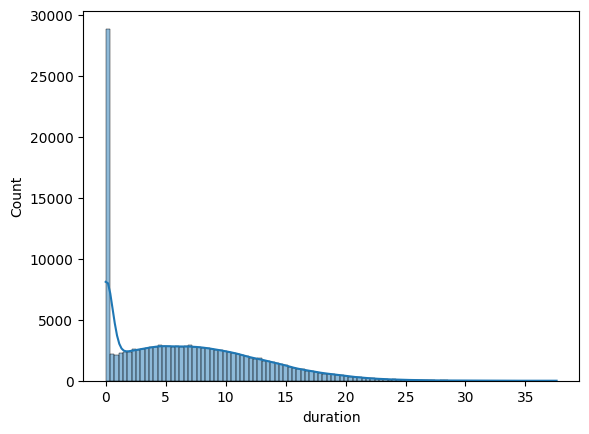

In [ ]:
#Observamos en el gráfico que 26834 llamdas duraron 0 minutos
sns.histplot(data=df_calls, x='duration', kde=True)
plt.show()

In [ ]:
#mostramos la información general de la tabla y vemos que quedó con los tipos de datos correctos
print(df_calls.info())
print()
df_calls.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB
None



,id,user_id,call_date,duration
136980,1496_149,1496,2018-12-21,0.00
57499,1206_282,1206,2018-11-23,4.58
37238,1141_108,1141,2018-10-31,1.30
8853,1041_288,1041,2018-06-05,7.44
116813,1408_462,1408,2018-09-17,1.10


Las llamadas que tienen 0 minutos de duración pueden ser llamadas perdidas o porque no hubo señal y no entraba la llamada, en cualquier caso dichas llamadas representan el 20%, en ese sentido no eliminaremos dichos registros porque podr+iamos perder información de otros registros de los usuarios cuando unamos las tablas. Simplemente las dejamos como 0 lo que significa que no consumieron minutos de su plan.

Nuestra tabla calls quedó con los tipos de datos correctos.

## Tabla mensajes

In [ ]:
#mostramos la tabla mensajes
print(df_messages.info())
print()
print(df_messages.duplicated().sum())
df_messages.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None

0


,id,user_id,message_date
4049,1043_6,1043,2018-12-14
6232,1055_350,1055,2018-07-30
55663,1349_586,1349,2018-12-30
54526,1346_28,1346,2018-09-19
34709,1220_227,1220,2018-09-28
59667,1379_144,1379,2018-12-13
66877,1434_434,1434,2018-10-15
23806,1144_294,1144,2018-09-18
42191,1273_102,1273,2018-10-15
42887,1281_105,1281,2018-08-08


Observamos que el campo message_date no tiene el formato tipo fecha. Todos los demás tipos están correctos y no hay nulos ni duplicados.

In [ ]:
#cambiamos la fecha al tipo correcto
df_messages['message_date'] = df_messages.message_date.astype('datetime64[D]')

#mostramos la información general
print(df_messages.info())
print()

#mostramos como quedó la tabla
df_messages.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB
None



,id,user_id,message_date
71531,1466_183,1466,2018-10-16
12468,1081_223,1081,2018-09-03
10874,1077_145,1077,2018-02-01
30582,1193_189,1193,2018-07-31
63776,1405_593,1405,2018-07-18


Nuestra tabla messages quedó con los tipos de datos correctos.

## Tabla internet

In [ ]:
#mostramos la tabla de internet
print(df_internet.info())
print()
print(df_internet.duplicated().sum())
print()
df_internet.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
None

0



,id,user_id,session_date,mb_used
41334,1185_371,1185,2018-10-17,375.34
1909,1010_65,1010,2018-03-12,473.68
80170,1374_246,1374,2018-08-18,940.17
31761,1144_507,1144,2018-09-03,859.59
18661,1083_191,1083,2018-12-08,447.60
79139,1368_333,1368,2018-09-16,490.35
84831,1397_18,1397,2018-09-07,512.54
19630,1088_452,1088,2018-07-11,273.62
44394,1196_404,1196,2018-03-19,646.69
43760,1194_178,1194,2018-09-17,46.15


Observamos que el campo session_date no tiene el formato tipo fecha. Todos los demás tipos están correctos y no hay nulos ni duplicados.

In [ ]:
#cambiamos la fecha al tipo correcto
df_internet['session_date'] = df_internet.session_date.astype('datetime64[D]')

In [ ]:
#mostramos los megas usados y observamos que hay 13747 registros con consumo de 0 megas
df_internet.groupby('mb_used')['user_id'].count()

mb_used
0.00       13747
0.01           1
0.02           2
0.03           1
0.04           2
           ...  
1604.46        1
1634.39        1
1636.47        1
1668.03        1
1693.47        1
Name: user_id, Length: 57624, dtype: int64

In [ ]:
#calculamos el porcentaje del total de los datos
len(df_internet[df_internet.mb_used == 0])/len(df_internet)

0.1311423801574052

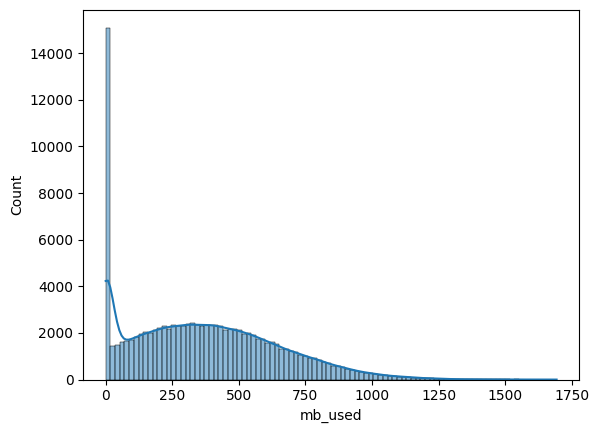

In [ ]:
#Observamos la mayor cantidad de registros está en torno a 0 megas
sns.histplot(data=df_internet, x='mb_used', kde=True)
plt.show()

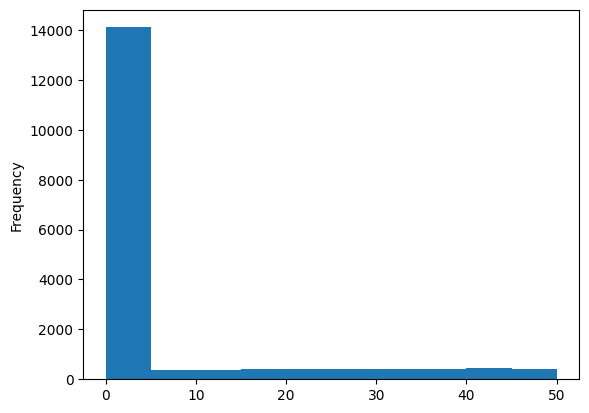

In [ ]:
#Observamos que de 0 a 5 megas hay alrededor de 14000 registros
df_internet.mb_used.plot(kind='hist', bins=10, range=(0,50))
plt.show()

In [ ]:
#mostramos la información general
print(df_internet.info())
print()

#mostramos como quedó la tabla
df_internet.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB
None



,id,user_id,session_date,mb_used
42852,1191_31,1191,2018-07-01,237.25
50327,1224_144,1224,2018-07-03,199.31
6604,1038_92,1038,2018-10-29,500.54
61041,1277_344,1277,2018-05-29,706.49
104219,1498_284,1498,2018-10-10,400.95


- Observamos que el tipo de dato fecha ahora tiene el formato correcto.
- Respecto a los megas consumidos que son igual a 0 (13% aproximadamente) e incluso los consumos de 0.01, 0.02, 0.03, etc., se pueden deber a que el usuario inició sesión usando  el internet de su hogar o trabajo por lo que no consumió los megas de su plan, es por ello que se observa registros sin consumo de megas y registros con muy poco consumo de megas. No eliminaremos estos registros por el porcentaje que representan frente al total y además para mo perder información de los usuarios cuando se haga una unión de tablas.

Nuestra tabla internet quedó con el tipo de dato correcto para la fecha, no hay nulo ni duplicados.

## Estudiamos las condiciones del plan

In [ ]:
#mostramos nuevamente la tabla de planes
df_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Filtramos datos por usuario

### 1. Cantidad de llamadas y cantidad de minutos hechas por cada usuario por mes

In [ ]:
#para calcular el número de llamadas y minutos hechas por cada usuario por mes agregaremos una columna de mes a la tabla df_calls
        #df_calls['month'] = pd.DatetimeIndex(df_calls.call_date).month #esta es otra forma de sacar el mes de una fecha
df_calls['month'] = df_calls.call_date.dt.month
df_calls.head()

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,8.52,12
1,1000_145,1000,2018-12-27,13.66,12
2,1000_247,1000,2018-12-27,14.48,12
3,1000_309,1000,2018-12-28,5.76,12
4,1000_380,1000,2018-12-30,4.22,12


In [ ]:
#de acuerdo a la descripción del proyecto, la empresa redondea los segundos consumidos por cada usuario en su llamada a minutos, es decir
#si un usuario hizo una llamada de 5.2 minutos, entonces este se redondea a 6 minutos.
#Entonces redondeamos hacia arriba la columna 'duration'
df_calls['duration'] = np.ceil(df_calls.duration).astype('int')
df_calls

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,15,12
3,1000_309,1000,2018-12-28,6,12
4,1000_380,1000,2018-12-30,5,12
...,...,...,...,...,...
137730,1499_199,1499,2018-11-21,9,11
137731,1499_200,1499,2018-10-20,11,10
137732,1499_201,1499,2018-09-21,9,9
137733,1499_202,1499,2018-10-10,1,10


In [ ]:
#ahora calculamos el número de llamadas y los mintuos utilizados por cada usuario por mes
calls_minutes_per_month = df_calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum'])
calls_minutes_per_month

count      sum
              duration duration
user_id month                  
1000    12          16      124
1001    8           27      182
        9           49      315
        10          65      393
        11          64      426
...                ...      ...
1498    12          39      339
1499    9           41      346
        10          53      385
        11          45      308
        12          65      496

[2258 rows x 2 columns]

In [ ]:
#pasamos los índices user_id y month a columnas
calls_minutes_per_month.reset_index(inplace=True)

In [ ]:
#mostramos como queda la tabla
calls_minutes_per_month

,user_id,month,count,sum
,,,duration,duration
0,1000,12,16,124
1,1001,8,27,182
2,1001,9,49,315
3,1001,10,65,393
4,1001,11,64,426
...,...,...,...,...
2253,1498,12,39,339
2254,1499,9,41,346
2255,1499,10,53,385


In [ ]:
#eliminamos el nivel 1 del encabezado
calls_minutes_per_month.columns = calls_minutes_per_month.columns.droplevel(1)
calls_minutes_per_month

,user_id,month,count,sum
0,1000,12,16,124
1,1001,8,27,182
2,1001,9,49,315
3,1001,10,65,393
4,1001,11,64,426
...,...,...,...,...
2253,1498,12,39,339
2254,1499,9,41,346
2255,1499,10,53,385
2256,1499,11,45,308


In [ ]:
#renombramos la columan count y sum por cantidad_llamadas y duracion_llamadas 
calls_minutes_per_month = calls_minutes_per_month.rename(columns={'count':'cantidad_llamadas', 'sum':'duration_minutes'})
calls_minutes_per_month

,user_id,month,cantidad_llamadas,duration_minutes
0,1000,12,16,124
1,1001,8,27,182
2,1001,9,49,315
3,1001,10,65,393
4,1001,11,64,426
...,...,...,...,...
2253,1498,12,39,339
2254,1499,9,41,346
2255,1499,10,53,385
2256,1499,11,45,308


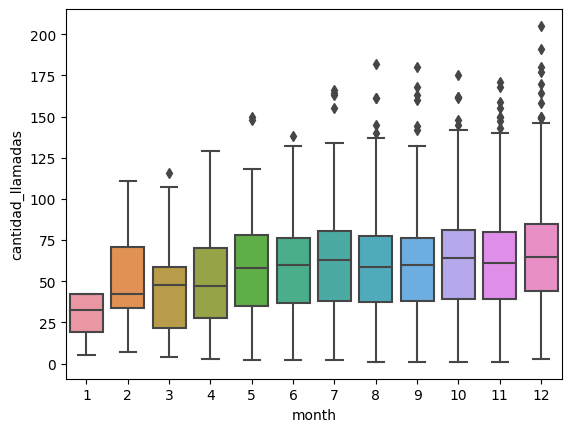

In [ ]:
sns.boxplot(data=calls_minutes_per_month, x='month', y='cantidad_llamadas')
plt.show()

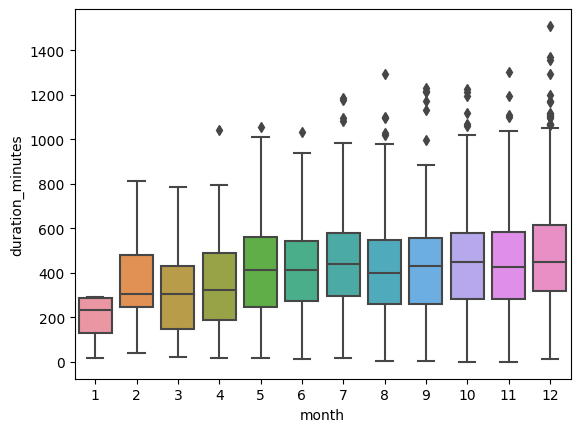

In [ ]:
sns.boxplot(data=calls_minutes_per_month, x='month', y='duration_minutes')
plt.show()

De acuerdo a los gráficos, entre los meses de octubre, noviembre y diciembre hay más llamadas realizadas por los usuarios y la duración de estas se mantien casi uniforme entre los meses de mayo y diciembre, sin embargo observamos datos atípicos. No eliminaremos dichos datos atípicos ya que son de utilidad para el análisis lo cual reflejaría con mayor claridad el comportamiento de los usuarios.

### 2. Mensajes enviados por cada usuario por mes

In [ ]:
#mostramos la tabla con la que trabajaremos
df_messages

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
...,...,...,...
76046,1497_526,1497,2018-12-24
76047,1497_536,1497,2018-12-24
76048,1497_547,1497,2018-12-31
76049,1497_558,1497,2018-12-24


In [ ]:
#agregamos uan columna con el mes
    #df_messages['month'] = pd.DatetimeIndex(df_messages.message_date).month
df_messages['month'] = df_messages.message_date.dt.month
df_messages

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12
...,...,...,...,...
76046,1497_526,1497,2018-12-24,12
76047,1497_536,1497,2018-12-24,12
76048,1497_547,1497,2018-12-31,12
76049,1497_558,1497,2018-12-24,12


In [ ]:
#calculamos la cantidad de mensajes enviados por cada usuario por mes
messages_per_month = df_messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_per_month

id
user_id month    
1000    12     11
1001    8      30
        9      44
        10     53
        11     36
...            ..
1496    9      21
        10     18
        11     13
        12     11
1497    12     50

[1806 rows x 1 columns]

In [ ]:
#establecemos los indices user_id y month como columnas
messages_per_month.reset_index(inplace=True)
#renombramos la columna id
messages_per_month = messages_per_month.rename(columns={'id':'cantidad_mensajes'})
#mostramos como queda la tabla
messages_per_month

,user_id,month,cantidad_mensajes
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


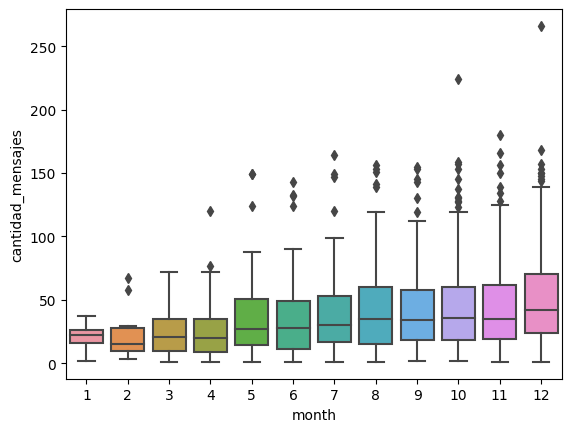

In [ ]:
sns.boxplot(data=messages_per_month, x='month', y='cantidad_mensajes')
plt.show()

No eliminaremos dichos datos atípicos ya que son de utilidad para el análisis lo cual reflejaría con mayor claridad el comportamiento de los usuarios.

In [ ]:
# EN CASO DE ELIMINAR ATIPICOS PODRÍAMOS USAR EL SIGUIENTE CÓDIGO:

# Q3 = messages_per_month[messages_per_month.month == 12]['cantidad_mensajes'].quantile(0.75) 
# Q1 = messages_per_month[messages_per_month == 12]['cantidad_mensajes'].quantile(0.25)
# IQR = Q3 - Q1
# upper_limit = Q3+1.5*IQR
# print('El límite teórico superior es: ', upper_limit)
# #filtramos los datos donde la cantidad_mensajes sea <= upper_limit
# messages_per_month = messages_per_month[messages_per_month.cantidad_mensajes <= upper_limit]

In [ ]:
#hacemos nuevamente el gráfico de cajas y bigotes sin la mayoría de datos atípicos
# sns.boxplot(data=messages_per_month, x='month', y='cantidad_mensajes')
# plt.show()

### 3. Gigabytes usados por cada usuario por mes

In [ ]:
#mostramos la tabla con la que trabajaremos
df_internet

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06
104821,1499_216,1499,2018-12-30,304.72
104822,1499_217,1499,2018-09-22,292.75
104823,1499_218,1499,2018-12-07,0.00


In [ ]:
#agregamos la columna de mes a nuestra tabla
    #df_internet['month'] = pd.DatetimeIndex(df_internet.session_date).month
df_internet['month'] = df_internet.session_date.dt.month
df_internet

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12
...,...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06,10
104821,1499_216,1499,2018-12-30,304.72,12
104822,1499_217,1499,2018-09-22,292.75,9
104823,1499_218,1499,2018-12-07,0.00,12


In [ ]:
#calculamos los gigabytes consumidos por cada usuario por mes
gb_per_month = df_internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
gb_per_month

mb_used
user_id month          
1000    12      1901.47
1001    8       6919.15
        9      13314.82
        10     22330.49
        11     18504.30
...                 ...
1498    12     23137.69
1499    9      12984.76
        10     19492.43
        11     16813.83
        12     22059.21

[2277 rows x 1 columns]

In [ ]:
#establecemos los indices user_id y month como columnas
gb_per_month.reset_index(inplace=True)

#de acuerdo a la descripción del proyecto, la empresa redondea hacia arriba (en gigabytes) el consumo mensual de cada usuario.
#1GB = 1024 Mb; si un usuario consumió 1025 Mb entonces el consumo es de 2 Gb.
# Entonces pasamos a gigabytes los mb
gb_per_month['mb_used'] = np.ceil(gb_per_month.mb_used/1024).astype('int')
#renombramos la columna mb_used
gb_per_month = gb_per_month.rename(columns={'mb_used':'gb_used'})
#mostramos como queda la tabla
gb_per_month

,user_id,month,gb_used
0,1000,12,2
1,1001,8,7
2,1001,9,14
3,1001,10,22
4,1001,11,19
...,...,...,...
2272,1498,12,23
2273,1499,9,13
2274,1499,10,20
2275,1499,11,17


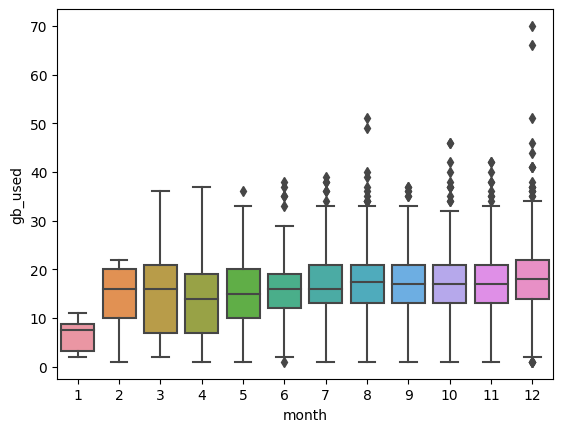

In [ ]:
sns.boxplot(data=gb_per_month, x='month', y='gb_used')
plt.show()

No eliminaremos dichos datos atípicos ya que son de utilidad para el análisis lo cual reflejaría con mayor claridad el comportamiento de los usuarios.

### 5. Combinamos las tablas creadas en una sola

In [ ]:
df_combined = calls_minutes_per_month.merge(messages_per_month, on=['user_id', 'month'], how='outer') #con outer mantenemos todos los datos
df_combined = df_combined.merge(gb_per_month, on=['user_id', 'month'], how='outer') # con outer mantenemos todos los datos
df_combined 

,user_id,month,cantidad_llamadas,duration_minutes,cantidad_mensajes,gb_used
0,1000,12,16.0,124.0,11.0,2.0
1,1001,8,27.0,182.0,30.0,7.0
2,1001,9,49.0,315.0,44.0,14.0
3,1001,10,65.0,393.0,53.0,22.0
4,1001,11,64.0,426.0,36.0,19.0
...,...,...,...,...,...,...
2288,1349,12,NaN,NaN,61.0,13.0
2289,1361,5,NaN,NaN,2.0,2.0
2290,1482,10,NaN,NaN,2.0,NaN
2291,1108,12,NaN,NaN,NaN,1.0


In [ ]:
#para mostrar los planes en la tabla combinada, tenemos que combinar la tabla anterior con la tabla de usuarios y luego hacer la combinación
#con la tabla de planes a tarvés del campo 'plan'
#Primero hacemos la combinación con la tabla usuarios df_users
df_combined = df_combined.merge(df_users, on='user_id', how='outer')
df_combined

,user_id,month,cantidad_llamadas,duration_minutes,cantidad_mensajes,gb_used,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,12.0,16.0,124.0,11.0,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2019-01-31
1,1001,8.0,27.0,182.0,30.0,7.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-31
2,1001,9.0,49.0,315.0,44.0,14.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-31
3,1001,10.0,65.0,393.0,53.0,22.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-31
4,1001,11.0,64.0,426.0,36.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,1307,NaN,NaN,NaN,NaN,NaN,Kristopher,Lang,28,"Boston-Cambridge-Newton, MA-NH MSA",2018-12-31,surf,2019-01-31
2299,1319,NaN,NaN,NaN,NaN,NaN,Eliseo,Carson,21,"Colorado Springs, CO MSA",2018-06-17,surf,2019-01-31
2300,1378,NaN,NaN,NaN,NaN,NaN,Mckinley,Clayton,22,"Denver-Aurora-Lakewood, CO MSA",2018-12-17,surf,2019-01-31
2301,1463,NaN,NaN,NaN,NaN,NaN,Dinorah,Simmons,30,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-11-27,ultimate,2019-01-31


In [ ]:
#ahora hacemos la combinación con la tabla planes para mostrar la información en una sola tabla
df_combined = df_combined.merge(df_plans, on='plan', how='inner')
df_combined

,user_id,month,cantidad_llamadas,duration_minutes,cantidad_mensajes,gb_used,first_name,last_name,age,city,reg_date,plan,churn_date,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,12.0,16.0,124.0,11.0,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2019-01-31,1000,30720,3000,70,7,0.01,0.01
1,1006,11.0,2.0,10.0,15.0,3.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,1000,30720,3000,70,7,0.01,0.01
2,1006,12.0,9.0,59.0,139.0,32.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,1000,30720,3000,70,7,0.01,0.01
3,1008,10.0,71.0,476.0,21.0,17.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,2019-01-31,1000,30720,3000,70,7,0.01,0.01
4,1008,11.0,63.0,446.0,37.0,24.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,2019-01-31,1000,30720,3000,70,7,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,1143,NaN,NaN,NaN,NaN,NaN,Lorina,Stevens,69,"Cincinnati, OH-KY-IN MSA",2018-10-26,surf,2019-01-31,50,15360,500,20,10,0.03,0.03
2299,1307,NaN,NaN,NaN,NaN,NaN,Kristopher,Lang,28,"Boston-Cambridge-Newton, MA-NH MSA",2018-12-31,surf,2019-01-31,50,15360,500,20,10,0.03,0.03
2300,1319,NaN,NaN,NaN,NaN,NaN,Eliseo,Carson,21,"Colorado Springs, CO MSA",2018-06-17,surf,2019-01-31,50,15360,500,20,10,0.03,0.03
2301,1378,NaN,NaN,NaN,NaN,NaN,Mckinley,Clayton,22,"Denver-Aurora-Lakewood, CO MSA",2018-12-17,surf,2019-01-31,50,15360,500,20,10,0.03,0.03


In [ ]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 0 to 2302
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                2303 non-null   int64         
 1   month                  2293 non-null   float64       
 2   cantidad_llamadas      2258 non-null   float64       
 3   duration_minutes       2258 non-null   float64       
 4   cantidad_mensajes      1806 non-null   float64       
 5   gb_used                2277 non-null   float64       
 6   first_name             2303 non-null   object        
 7   last_name              2303 non-null   object        
 8   age                    2303 non-null   int64         
 9   city                   2303 non-null   object        
 10  reg_date               2303 non-null   datetime64[ns]
 11  plan                   2303 non-null   object        
 12  churn_date             2303 non-null   datetime64[ns]
 13  mes

Observamos que todos los campos tienen el tipo de dato correcto y no hay valores nulos a excepción de cinco campos:
- ``cantidad_llamadas``: tiene registros nulos porque los usuarios no hicieron llamadas en ese mes, por lo tanto reemplazaremos los nulos por ``0``.
- ``dration_minutes:`` tiene campos nulos ya que si no se hicieron llamadas o si se hicieron pero nadie respondió entonces no se consumieron minutos, por tanto reemplazamos de igual
manera los nulos por ``0``.
- ``cantidad_mensajes``: tiene registros nulos debido a que los usuarios no realizaron envios de mensajes en ese mes. Reemplazamos de igual
forma los nulos por ``0``.
- ``gb_used`` :  tiene registros nulos debido a que los usuarios no realizaron consumo de datos en ese mes. Reemplazamos de igual
forma los nulos por ``0``.
- ``month`` : este es una campo curioso, los meses figuran como nulos porque dichos usuarios no realizaron ningún consumo de megas, ni de minutos ni de mensajes. Esto quiere decir que en ninguna fecha del 2018 estos usuarios usaron su plan por lo que tiene sentido reemplazar estos valores nulos por ``0``, este nuevo valor del mes indicará que dichos usuarios no realizaron ningpun consumo de su plan durante todo el año.

In [ ]:
#reemplazamos los nulos por cero
df_combined.fillna(0, inplace=True)

In [ ]:
#mostramos la información general de nuestro dataframe y observamos que ya no hay nulos y los tipos de datos son los correctos
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 0 to 2302
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                2303 non-null   int64         
 1   month                  2303 non-null   float64       
 2   cantidad_llamadas      2303 non-null   float64       
 3   duration_minutes       2303 non-null   float64       
 4   cantidad_mensajes      2303 non-null   float64       
 5   gb_used                2303 non-null   float64       
 6   first_name             2303 non-null   object        
 7   last_name              2303 non-null   object        
 8   age                    2303 non-null   int64         
 9   city                   2303 non-null   object        
 10  reg_date               2303 non-null   datetime64[ns]
 11  plan                   2303 non-null   object        
 12  churn_date             2303 non-null   datetime64[ns]
 13  mes

En la tabla combinada ``df_combined`` observamos que la columna ``mb_per_month_included`` contiene los datos del plan en *mb* y el cobro adicional que hace la empresa es en base a los gigas consumidos, en ese sentido pasaremos los mb a gigabytes.

In [ ]:
#hacemos la conversión
df_combined['mb_per_month_included'] = df_combined['mb_per_month_included']/1024
#renombramos la columna
df_combined = df_combined.rename(columns={'mb_per_month_included':'gb_per_month_included'})
#cambiamos también los tipos de datos de cantidad_llamadas, duration_minutes y cantidad_mensajes a tipo entero. Esto porque las cantidades 
#de llamadas y mensajes no pueden ser decimal y la duración de la llamada fue redondeada hacia arriba a minutos.
#también cambiamos el tipo de dato de la columna gb_per_month_included a entero
df_combined['cantidad_llamadas'] = df_combined['cantidad_llamadas'].astype('int')
df_combined['duration_minutes'] = df_combined['duration_minutes'].astype('int')
df_combined['cantidad_mensajes'] = df_combined['cantidad_mensajes'].astype('int')
df_combined['gb_per_month_included'] = df_combined['gb_per_month_included'].astype('int')

In [ ]:
#mostramos la información de la tabla
print(df_combined.info())
print()
#mostramos como quedó la tabla
df_combined

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 0 to 2302
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                2303 non-null   int64         
 1   month                  2303 non-null   float64       
 2   cantidad_llamadas      2303 non-null   int32         
 3   duration_minutes       2303 non-null   int32         
 4   cantidad_mensajes      2303 non-null   int32         
 5   gb_used                2303 non-null   float64       
 6   first_name             2303 non-null   object        
 7   last_name              2303 non-null   object        
 8   age                    2303 non-null   int64         
 9   city                   2303 non-null   object        
 10  reg_date               2303 non-null   datetime64[ns]
 11  plan                   2303 non-null   object        
 12  churn_date             2303 non-null   datetime64[ns]
 13  mes

,user_id,month,cantidad_llamadas,duration_minutes,cantidad_mensajes,gb_used,first_name,last_name,age,city,reg_date,plan,churn_date,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,12.0,16,124,11,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2019-01-31,1000,30,3000,70,7,0.01,0.01
1,1006,11.0,2,10,15,3.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,1000,30,3000,70,7,0.01,0.01
2,1006,12.0,9,59,139,32.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,1000,30,3000,70,7,0.01,0.01
3,1008,10.0,71,476,21,17.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,2019-01-31,1000,30,3000,70,7,0.01,0.01
4,1008,11.0,63,446,37,24.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,2019-01-31,1000,30,3000,70,7,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,1143,0.0,0,0,0,0.0,Lorina,Stevens,69,"Cincinnati, OH-KY-IN MSA",2018-10-26,surf,2019-01-31,50,15,500,20,10,0.03,0.03
2299,1307,0.0,0,0,0,0.0,Kristopher,Lang,28,"Boston-Cambridge-Newton, MA-NH MSA",2018-12-31,surf,2019-01-31,50,15,500,20,10,0.03,0.03
2300,1319,0.0,0,0,0,0.0,Eliseo,Carson,21,"Colorado Springs, CO MSA",2018-06-17,surf,2019-01-31,50,15,500,20,10,0.03,0.03
2301,1378,0.0,0,0,0,0.0,Mckinley,Clayton,22,"Denver-Aurora-Lakewood, CO MSA",2018-12-17,surf,2019-01-31,50,15,500,20,10,0.03,0.03


In [ ]:
#por ejemplo mostramos la información del usuario 1009
df_combined[df_combined.user_id == 1009]

,user_id,month,cantidad_llamadas,duration_minutes,cantidad_mensajes,gb_used,first_name,last_name,age,city,reg_date,plan,churn_date,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
747,1009,5.0,71,534,0,20.0,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,2019-01-31,50,15,500,20,10,0.03,0.03
748,1009,6.0,110,823,0,19.0,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,2019-01-31,50,15,500,20,10,0.03,0.03
749,1009,7.0,124,880,0,30.0,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,2019-01-31,50,15,500,20,10,0.03,0.03
750,1009,8.0,109,731,0,24.0,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,2019-01-31,50,15,500,20,10,0.03,0.03
751,1009,9.0,116,776,0,21.0,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,2019-01-31,50,15,500,20,10,0.03,0.03
752,1009,10.0,114,740,0,23.0,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,2019-01-31,50,15,500,20,10,0.03,0.03
753,1009,11.0,105,714,0,25.0,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,2019-01-31,50,15,500,20,10,0.03,0.03
754,1009,12.0,107,756,0,24.0,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,2019-01-31,50,15,500,20,10,0.03,0.03


Observamos que el usuario se llama Gerry Little, tiene 19 años, es de San Jose-CA, se registró al plan surf el 22 de abril del 2018 y aún continúa vigente con dicho plan. 

Apreciamos también que no ha enviado ningún mensaje desde que adquirió su plan, sin embargo ha sobrepasado los consumos que le permiten su plan en lo que respecta a los minutos de llamadas y los gigas por lo que seguramente la compañía le cobrará un adicional por sobrepasar el límite.

A continuación calcularemos los ingresos mensuales que cada usuario aporta a la compañía. Como vimos con Gerry, dicho usuario no solo tendrá que pagar mensualmente el costo de su plan, que es de $20, sino también las tarifas por el consumo extra que hizo de su plan, tal como ocurrió con los minutos de llamadas y el volumen de gigabytes usados. 

In [ ]:
#crearemos tres columnas que muestren el exceso de consumo del usuario respecto al plan adquirido
df_combined['minutes_exceded'] = df_combined['duration_minutes'] - df_combined['minutes_included']
df_combined['messages_exceded'] = df_combined['cantidad_mensajes'] - df_combined['messages_included']
df_combined['gb_exceded'] = df_combined['gb_used'] - df_combined['gb_per_month_included']

In [ ]:
#de acuerdo al plan (surf o ultimate) calcularemos en unas nuevas tres columnas los ingresos de los excesos de los minutos, mensajes y gb consumidos
condition_list = [df_combined.plan == 'surf', df_combined.plan == 'ultimate']
calc_minutes_list = [df_combined['minutes_exceded']*0.03, df_combined['minutes_exceded']*0.01]
calc_message_list = [df_combined['messages_exceded']*0.03, df_combined['messages_exceded']*0.01]
calc_gb_list = [df_combined['gb_exceded']*10, df_combined['gb_exceded']*7]
#agregamos las columnas con los precios del exceso
df_combined['usd_minutes_exceded'] = np.select(condition_list, calc_minutes_list)
df_combined['usd_messages_exceded'] = np.select(condition_list, calc_message_list)
df_combined['usd_gb_exceded'] = np.select(condition_list, calc_gb_list)

In [ ]:
#debido a que hay excesos negativos y por lo tanto el precio es negativo (esto porque el consumo por el usuario fue menor que el plan y por tanto
#no hubo exceso), vamos a actualizar las columnas: cuando el valor sea negativo pondremos 0 y si es mayor o igual a 0 que quede el mismo valor (precio)
df_combined['usd_minutes_exceded'] = np.where(df_combined.usd_minutes_exceded < 0, 0, df_combined.usd_minutes_exceded)
df_combined['usd_messages_exceded'] = np.where(df_combined.usd_messages_exceded < 0, 0, df_combined.usd_messages_exceded)
df_combined['usd_gb_exceded'] = np.where(df_combined.usd_gb_exceded < 0, 0, df_combined.usd_gb_exceded)

In [ ]:
#ahora sumamos las tres columnas de los precios calculados debido al exceso y agregaremos al costo del plan mensual ($20 o $70) y de esa forma
#tendremos el ingreso mensual total que la empresa recibe por usuario
cond_list = [df_combined.plan == 'surf', df_combined.plan == 'ultimate']
calculate_list = [df_combined['usd_minutes_exceded']+df_combined['usd_messages_exceded']+df_combined['usd_gb_exceded']+20,
                  df_combined['usd_minutes_exceded']+df_combined['usd_messages_exceded']+df_combined['usd_gb_exceded']+70]

df_combined['total_income'] = np.select(cond_list, calculate_list)

In [ ]:
df_combined

,user_id,month,cantidad_llamadas,duration_minutes,cantidad_mensajes,gb_used,first_name,last_name,age,city,...,usd_per_gb,usd_per_message,usd_per_minute,minutes_exceded,messages_exceded,gb_exceded,usd_minutes_exceded,usd_messages_exceded,usd_gb_exceded,total_income
0,1000,12.0,16,124,11,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",...,7,0.01,0.01,-2876,-989,-28.0,0.0,0.0,0.0,70.0
1,1006,11.0,2,10,15,3.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",...,7,0.01,0.01,-2990,-985,-27.0,0.0,0.0,0.0,70.0
2,1006,12.0,9,59,139,32.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",...,7,0.01,0.01,-2941,-861,2.0,0.0,0.0,14.0,84.0
3,1008,10.0,71,476,21,17.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",...,7,0.01,0.01,-2524,-979,-13.0,0.0,0.0,0.0,70.0
4,1008,11.0,63,446,37,24.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",...,7,0.01,0.01,-2554,-963,-6.0,0.0,0.0,0.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,1143,0.0,0,0,0,0.0,Lorina,Stevens,69,"Cincinnati, OH-KY-IN MSA",...,10,0.03,0.03,-500,-50,-15.0,0.0,0.0,0.0,20.0
2299,1307,0.0,0,0,0,0.0,Kristopher,Lang,28,"Boston-Cambridge-Newton, MA-NH MSA",...,10,0.03,0.03,-500,-50,-15.0,0.0,0.0,0.0,20.0
2300,1319,0.0,0,0,0,0.0,Eliseo,Carson,21,"Colorado Springs, CO MSA",...,10,0.03,0.03,-500,-50,-15.0,0.0,0.0,0.0,20.0
2301,1378,0.0,0,0,0,0.0,Mckinley,Clayton,22,"Denver-Aurora-Lakewood, CO MSA",...,10,0.03,0.03,-500,-50,-15.0,0.0,0.0,0.0,20.0


In [ ]:
#retiramos las columnas que ya no nos sirven
df_combined = df_combined.drop(['usd_monthly_pay',
                                'usd_per_gb', 'usd_per_message', 'usd_per_minute', 'minutes_exceded', 'messages_exceded',
                                'gb_exceded', 'usd_messages_exceded', 'usd_minutes_exceded', 'usd_gb_exceded'], axis=1)

#mostramos la tabla
df_combined

,user_id,month,cantidad_llamadas,duration_minutes,cantidad_mensajes,gb_used,first_name,last_name,age,city,reg_date,plan,churn_date,messages_included,gb_per_month_included,minutes_included,total_income
0,1000,12.0,16,124,11,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2019-01-31,1000,30,3000,70.0
1,1006,11.0,2,10,15,3.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,1000,30,3000,70.0
2,1006,12.0,9,59,139,32.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,1000,30,3000,84.0
3,1008,10.0,71,476,21,17.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,2019-01-31,1000,30,3000,70.0
4,1008,11.0,63,446,37,24.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,2019-01-31,1000,30,3000,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,1143,0.0,0,0,0,0.0,Lorina,Stevens,69,"Cincinnati, OH-KY-IN MSA",2018-10-26,surf,2019-01-31,50,15,500,20.0
2299,1307,0.0,0,0,0,0.0,Kristopher,Lang,28,"Boston-Cambridge-Newton, MA-NH MSA",2018-12-31,surf,2019-01-31,50,15,500,20.0
2300,1319,0.0,0,0,0,0.0,Eliseo,Carson,21,"Colorado Springs, CO MSA",2018-06-17,surf,2019-01-31,50,15,500,20.0
2301,1378,0.0,0,0,0,0.0,Mckinley,Clayton,22,"Denver-Aurora-Lakewood, CO MSA",2018-12-17,surf,2019-01-31,50,15,500,20.0


In [ ]:
#calculamos el porcentaje que representan los las llamdas que duraron 0 minutos respecto al total
len(df_combined[df_combined.duration_minutes == 0])/len(df_combined)

0.02040816326530612

In [ ]:
#calculamos el porcentaje que representan la cantidad de mensajes igual a 0 respecto al total
len(df_combined[df_combined.cantidad_mensajes == 0])/len(df_combined)

0.21580547112462006

In [ ]:
#calculamos el porcentaje que representan los gb consumidos igual a 0 respecto al total
len(df_combined[df_combined.gb_used == 0])/len(df_combined)

0.011289622231871473

- Observamos que las llamadas que duraron 0 minutos es despreciable (2% aproximadamente).
- Observamos que el consumo de magas igual a 0 también es despreciable (1% aproximadamente).
- Observamos que en algunos meses los usuarios no enviaron mensajes de texto, esto representa un 22% del total de los datos.

No vamos a eliminar ningún registro porque justamente estamos evaluando como se comportan los usuarios en sus respectivos planes y como esto se ve reflejado en el ingreso mensual de la empresa Megaline.

Listo, ya tenemos nuestra tabla df_combined con los campos:
- Cantidad de llamadas realizada por usuario en un mes específico.
- Cantidad de minutos consumidos por usuario en un mes específico.
- Volumen de datos (en gigabytes) consumidos por usuario en un mes específico.
- Ingreso total mensual que recibe la empresa Megaline por usuario y mes.
- El código de usuario, su nombre, edad, fecha que activó su plan, fecha en la que se desactivó o aún sigue activo y las características del plan al que está afiliado.

Ahora procederemos a analizar el comportamiento del usuario.

### COMPORTAMIENTO DEL USUARIO
Antes que nada calculemos la cantidad de usuarios de cada plan:

In [ ]:
#Observamos que los usuarios del plan surf son un poco más del doble que los del plan ultimate
print('Cantidad de usuarios del plan ultimate: ', len(df_combined[df_combined.plan == 'ultimate']), '\n')
print('Cantidad de usuarios del plan surf: ', len(df_combined[df_combined.plan == 'surf']))

Cantidad de usuarios del plan ultimate:  724 

Cantidad de usuarios del plan surf:  1579


#### **A. Respecto a las llamadas**

#### 1. Trazamos un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

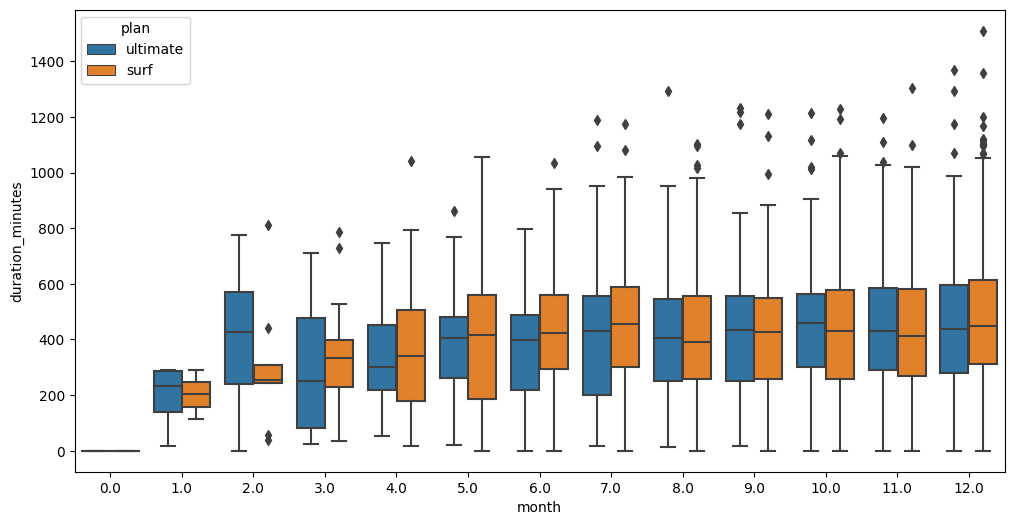

In [ ]:
fig = plt.figure(figsize=(12,6))
sns.boxplot(data=df_combined, x='month', y='duration_minutes', hue='plan')
plt.show()

In [ ]:
#PODRIAMOS HACER TAMBIEN UN GRÁFICO DE BARRAS PERO DARIA LA MISMA INFORMACION QUE EL GRÁFICO DE CAJAS. 
# NOTA: EL GRAFICO DE CAJAS DA MAS INFORMACION QUE EL GRAFICO DE BARRAS

# #df_combined.groupby('month')['duration_minutes'].mean().plot(kind='bar')
# fig = plt.figure(figsize=(12,6))
# sns.barplot(data=df_combined, x='month', y='duration_minutes', hue='plan', estimator='mean', errorbar=None)
# #por defecto estimator=mean y errobar=('ci', 95)
# plt.show()

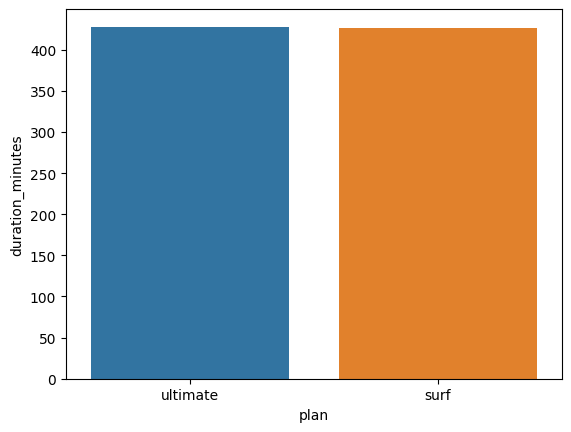

plan
surf        427.120329
ultimate    428.071823
Name: duration_minutes, dtype: float64

In [ ]:
#comparamos la duración promedio de llamadas por plan durante el año 2018 (todos los meses)
sns.barplot(data=df_combined, x='plan', y=df_combined['duration_minutes'], estimator='mean', errorbar=None)
#por defecto estimator=mean y errobar=('ci', 95)
plt.show()
df_combined.groupby('plan')['duration_minutes'].mean()

Observamos del primer gráfico que la distribución mensual de las llamadas para ambos planes es casi la misma con una mediana similar en todos los meses a excepción de febrero y marzo principalmete, en otras palabras no hay mucha diferencia en los diagramas de caja. Se observa que hay llamadas con una duración acumulada por encima de los 1000 minutos en el mes de diciembre para los usuarios surf principalmente. En febrero y marzo hubo más duración de llamadas del plan ultimate, pero es un caso aislado, en general la distribución es similar en ambos planes. ``Recordemos que el mes 0 indica que los usuarios no realizaron ninguna llamada, envio de mensajes o consumo de gigas.``

Respecto al segundo gráfico, se muestra el consumo promedio anual (todo el 2018) de los usuarios de ambos planes y como era de esperar y siendo coherente con la primera gráfica, se nota que el promedio de consumo es prácticamente el mismo: ``427.12 minutos para el plan surf`` y ``428 minutos para el plan ultimate.``

#### 2. Comparamos el número de minutos que los usuarios de cada plan requieren cada mes.

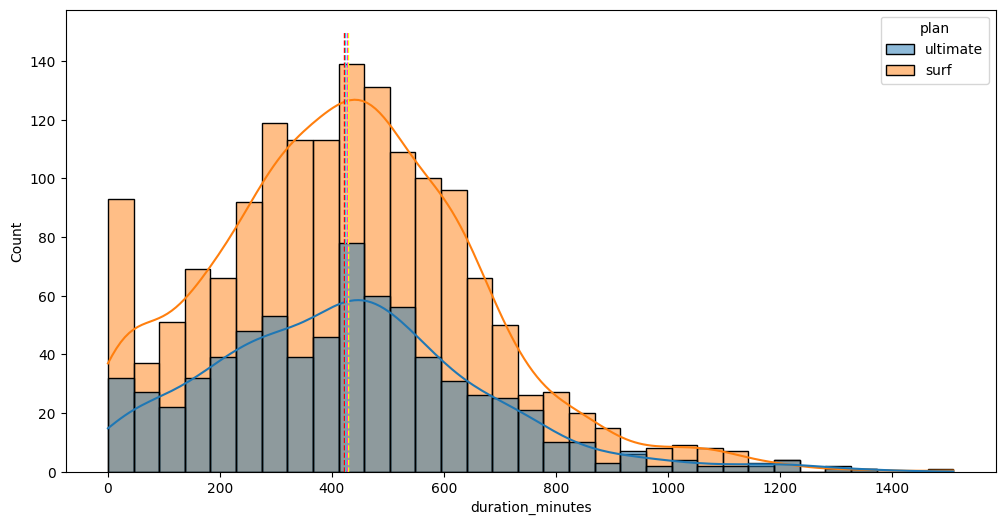

In [ ]:
fig = plt.figure(figsize=(12,6))
sns.histplot(data=df_combined, x='duration_minutes', hue='plan', kde=True)
plt.vlines(df_combined[df_combined.plan == 'surf']['duration_minutes'].mean(), colors='magenta', linestyles='dashed', linewidth=1, ymin=0, ymax=150)
plt.vlines(df_combined[df_combined.plan == 'surf']['duration_minutes'].median(), colors='cyan', linestyles='dashed', linewidth=1, ymin=0, ymax=150)
plt.vlines(df_combined[df_combined.plan == 'ultimate']['duration_minutes'].mean(), colors='yellow', linestyles='dashed', linewidth=1, ymin=0, ymax=150)
plt.vlines(df_combined[df_combined.plan == 'ultimate']['duration_minutes'].median(), colors='red', linestyles='dashed', linewidth=1, ymin=0, ymax=150)
plt.show()

Observamos en el histograma que la media y la mediana de los planes surf y ultimate no distan mucho una de otra por lo que cualquiera de ellas sería una buena métrica e indica que el comportamiento de los usuarios de ambos planes no difiere mucho. 

Sin embargo apreciamos que los hay ``más frecuencia de minutos de los usuarios del plan surf``, especialmente en el rango de duración de 200 a 650 minutos respecto a los usuarios del plan ultimate. Esto se debe a que los usuarios del plan surf son más que los del plan ultimate.

Observamos también que hay un pico en las llamadas que duraron entre 0 y 50 minutos, para el plan surf principalmente.

A continuación mostraremos los valores no solo de la media y mediana sino también de la varianza y la desviación estándar.

In [ ]:
print('USUARIOS DEL PLAN SURF:')
print('Media de la duración mensual de llamadas: ', df_combined[df_combined.plan == 'surf']['duration_minutes'].mean())
print('Mediana de la duración mensual de llamadas: ', df_combined[df_combined.plan == 'surf']['duration_minutes'].median())
print('Varianza de la duración mensual de llamadas: ', df_combined[df_combined.plan == 'surf']['duration_minutes'].var())
print('Desviación estándar de la duración mensual de llamadas: ', df_combined[df_combined.plan == 'surf']['duration_minutes'].std(), '\n')
print('USUARIOS DEL PLAN ULTIMATE:')
print('Media de la duración mensual de llamadas: ', df_combined[df_combined.plan == 'ultimate']['duration_minutes'].mean())
print('Mediana de la duración mensual de llamadas: ', df_combined[df_combined.plan == 'ultimate']['duration_minutes'].median())
print('Varianza de la duración mensual de llamadas: ', df_combined[df_combined.plan == 'ultimate']['duration_minutes'].var())
print('Desviación estándar de la duración mensual de llamadas: ', df_combined[df_combined.plan == 'ultimate']['duration_minutes'].std())

USUARIOS DEL PLAN SURF:
Media de la duración mensual de llamadas:  427.12032932235593
Mediana de la duración mensual de llamadas:  424.0
Varianza de la duración mensual de llamadas:  55455.57740014497
Desviación estándar de la duración mensual de llamadas:  235.49007919686335 

USUARIOS DEL PLAN ULTIMATE:
Media de la duración mensual de llamadas:  428.0718232044199
Mediana de la duración mensual de llamadas:  421.5
Varianza de la duración mensual de llamadas:  58543.878651719744
Desviación estándar de la duración mensual de llamadas:  241.9584233948464


Se aprecia que la variación entre las métricas, tanto para los planes ``surf`` y ``ultimate``, es prácticamente cero habiendo menos diferencia entre la media y la mediana en la duración de las llamadas para ambos planes (tal como se observa en el histograma). La variación entre las desviaciones estándar y varianza también es muy estrecha.

La varianza en ambos planes es elevado, esto indica que hay duraciones de llamadas muy por encima y muy por debajo (0 minutos) de la media y la mediana, tal como se observa en el histograma.

Como en ambos planes ocurre lo mismo, esto indica que no hay diferencia en el comportamiento de los usuarios ya sea que usen el plan ``surf`` o ``ultimate``.

**Conclusiones respecto al comportamiento de los usuarios referente a las llamadas por plan ``surf y ultimate``:**
- El promedio de la duración de las llamadas realizadas por mes y por plan es prácticamente el mismo en ambos planes.
- El promedio anual de la duración de las llamadas realizadas por plan es prácticamente el mismo en ambos planes.
- La media, la mediana, la desviación estándar y la varianza de la duración de las llamadas por plan es prácticamente el mismo.
- La frecuencia de la duración de las llamadas para los planes surf y ultimate son distintos, se observa que hay más llamadas de los usuarion con planes surf que ultimate. Esto se debe a que hay más usuarios que pertenecen al plan sur que al utlimate.
- la distribución de la duración de las llamadas por mes en ambos planes no varía mucho, según los diagramas de cajas existen mínimos de 0 minutos de duración y los máximos de duración es prácticamente lo mismo en ambos planes.

Por consiguiente *``no existe diferencia en el comportamiento de los usuarios en referencia a las llamadas, de acuerdo al histograma los usuarios con plan surf realizan más llamadas que los del plan ultimate sin embargo el promedio de duración de las llamadas es prácticamente la misma en ambos planes``*.

#### **B. Respecto a los mensajes**

#### 1. Trazamos un diagrama de caja para visualizar la distribución de la cantidad mensual de mensajes enviados por plan

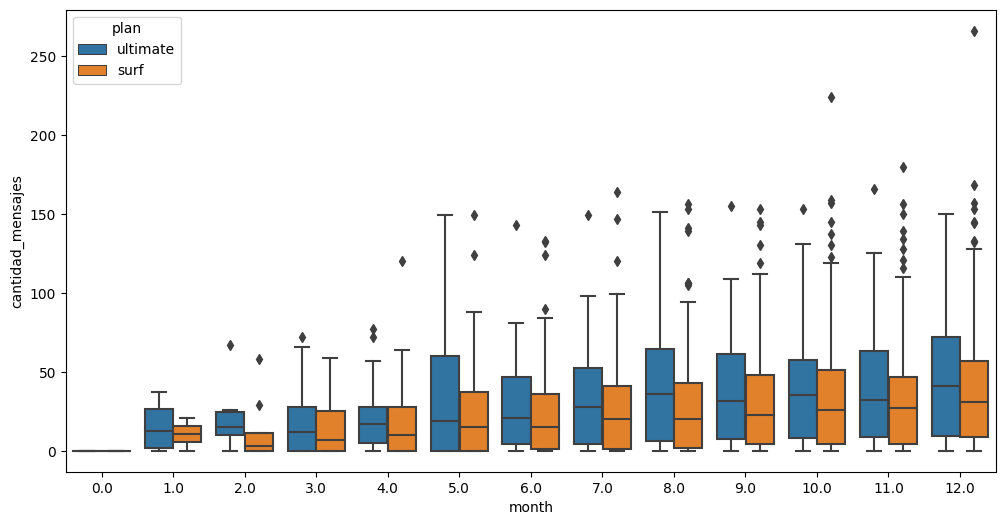

In [ ]:
fig = plt.figure(figsize=(12,6))
sns.boxplot(data=df_combined, x='month', y='cantidad_mensajes', hue='plan')
plt.show()

El gráfico muestra que en casi todos los meses la mínima cantidad de mensajes enviado fue cero y el 25% de los registros son 0 o cercano a cero. Observamos del gráfico que la distribución mensual de la cantidad de mensajes para ambos planes es diferente, hay más cantidad de mensajes de los usuario ultimate que los del plan surf. El máximo numero de mensajes que se envia mensualmente en promedio es de 37 para el plan ultimate. Un valor muy bajo teniendo en cuenta que el plan ultimate ofrece 1000 mensajes al mes. ``Recordemos que el mes 0 indica que los usuarios no realizaron ninguna llamada, envio de mensajes o consumo de gigas.``

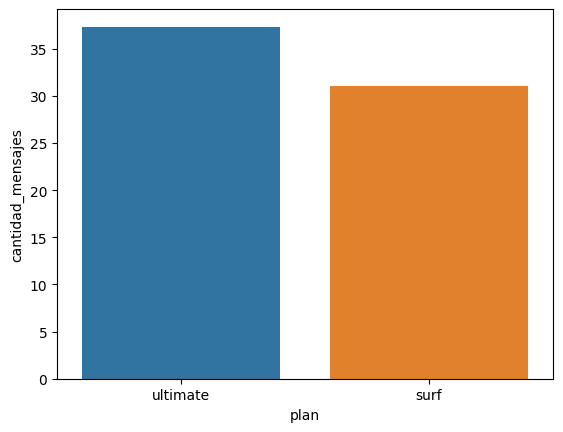

plan
surf        31.041165
ultimate    37.343923
Name: cantidad_mensajes, dtype: float64

In [ ]:
#comparamos la cantidad promedio de mensajes por plan durante el año 2018 (todos los meses)
sns.barplot(data=df_combined, x='plan', y='cantidad_mensajes', errorbar=None)
#por defecto estimator=mean y errobar=('ci', 95)
plt.show()
df_combined.groupby('plan')['cantidad_mensajes'].mean()

En este gráfico se aprecia mejor que los usuarios con plan ultimate envian en promedio más mensajes que los usuarios de surf. Sin embargo la diferencia no es mucha: ``31 mensajes en promedio para surf y 37 mensajes en promedio para ultimate``. 

- Estas cantidades de mensajes son muy bajas para el plan ultimate ya que dicho plan ofrece 1000 mensajes por mes. 
- Respecto al plan surf, los usuarios usan un poco más de la mitad de la cantidad de mensajes que su plan les ofrece, dicho plan ofrece 50 mensajes por mes.

#### 2. Comparamos la frecuencia de mensajes que los usuarios de cada plan envian cada mes.

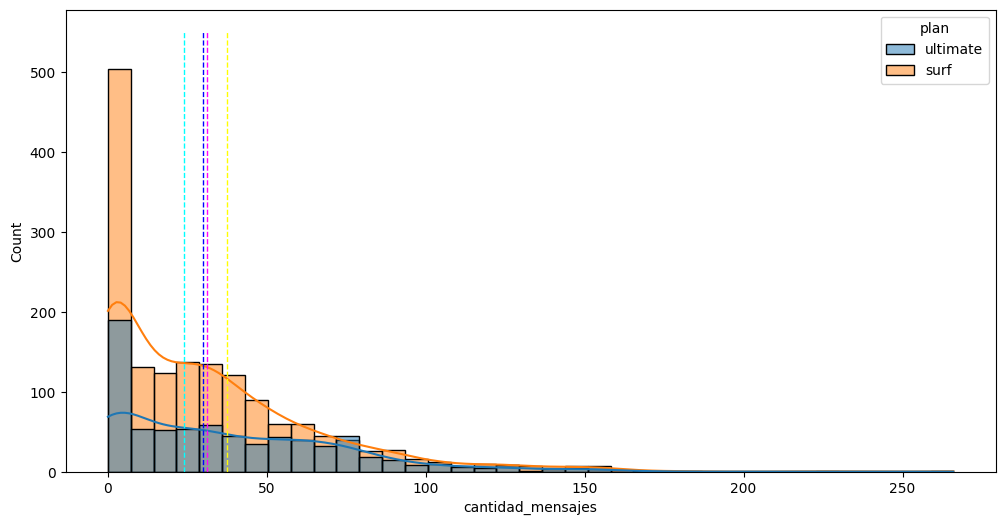

In [ ]:
fig = plt.figure(figsize=(12,6))
sns.histplot(data=df_combined, x='cantidad_mensajes', hue='plan', kde=True)
plt.vlines(df_combined[df_combined.plan == 'surf']['cantidad_mensajes'].mean(), colors='magenta', linestyles='dashed', linewidth=1, ymin=0, ymax=550)
plt.vlines(df_combined[df_combined.plan == 'surf']['cantidad_mensajes'].median(), colors='cyan', linestyles='dashed', linewidth=1, ymin=0, ymax=550)
plt.vlines(df_combined[df_combined.plan == 'ultimate']['cantidad_mensajes'].mean(), colors='yellow', linestyles='dashed', linewidth=1, ymin=0, ymax=550)
plt.vlines(df_combined[df_combined.plan == 'ultimate']['cantidad_mensajes'].median(), colors='blue', linestyles='dashed', linewidth=1, ymin=0, ymax=550)
plt.show()

Observamos en el histograma que la media y la mediana entre los planes surf y ultimate distan algo una de otra por lo que indica que la cantidad de mensajes más grandes arrastran a la media hacia la derecha. 

También apreciamos que hay ``más frecuencia de mensajes de los usuarios del plan surf``(debido a que hay mas usuarios de este plan), especialmente en el rango de 0 mensajes respecto a los usuarios del plan ultimate. Esto debido a que (como lo vimos más arriba) el 22% de los usuarios no envia mensajes.

A continuación mostraremos los valores no solo de la media y mediana sino también de la varianza y la desviación estándar.

In [ ]:
print('USUARIOS DEL PLAN SURF:')
print('Media de la cantidad mensual de mensajes: ', df_combined[df_combined.plan == 'surf']['cantidad_mensajes'].mean())
print('Mediana de la cantidad mensual de mensajes: ', df_combined[df_combined.plan == 'surf']['cantidad_mensajes'].median())
print('Varianza de la cantidad mensual de mensajes: ', df_combined[df_combined.plan == 'surf']['duration_minutes'].var())
print('Desviación estándar de la cantidad mensual de mensajes: ', df_combined[df_combined.plan == 'surf']['duration_minutes'].std(), '\n')
print('USUARIOS DEL PLAN ULTIMATE:')
print('Media de la cantidad mensual de mensajes: ', df_combined[df_combined.plan == 'ultimate']['cantidad_mensajes'].mean())
print('Mediana de la cantidad mensual de mensajes: ', df_combined[df_combined.plan == 'ultimate']['cantidad_mensajes'].median())
print('Varianza de la cantidad mensual de mensajes: ', df_combined[df_combined.plan == 'ultimate']['cantidad_mensajes'].var())
print('Desviación estándar de la cantidad mensual de mensajes: ', df_combined[df_combined.plan == 'ultimate']['cantidad_mensajes'].std())

USUARIOS DEL PLAN SURF:
Media de la cantidad mensual de mensajes:  31.041165294490185
Mediana de la cantidad mensual de mensajes:  24.0
Varianza de la cantidad mensual de mensajes:  55455.57740014497
Desviación estándar de la cantidad mensual de mensajes:  235.49007919686335 

USUARIOS DEL PLAN ULTIMATE:
Media de la cantidad mensual de mensajes:  37.3439226519337
Mediana de la cantidad mensual de mensajes:  30.0
Varianza de la cantidad mensual de mensajes:  1209.8276117007863
Desviación estándar de la cantidad mensual de mensajes:  34.78257626600977


Se aprecia que la variación entre las métricas media y mediana, tanto para los planes ``surf`` y ``ultimate``, distan algo entre si. ``La variación entre las desviaciones estándar y varianzaes muy alta``.

La varianza en ambos planes es elevado, esto indica que hay muchos mensajes muy por encima y debajo (0 mensajes) de la media y la mediana, tal como se observa en el histograma. Esto es más notorio en los usuarios del ``plan surf cuya varianza es de 55455.58``, una cifra bastante elevada.

El comportamiento de los usuarios en este caso, son diferentes debido a que las varianzas y desviaciones estándar son muy diferentes y la media y la mediana también son algo diferentes. Los`` usuarios del plan surf tienden a enviar más mensajes incluso superando lo permitido por su plan que es de 50 mensajes.``

**Conclusiones respecto al comportamiento de los usuarios referente a los mensajes por plan ``surf y ultimate``:**
- El promedio de la cantidad de mensaje realizadas por mes y por plan es mayor en los usuarios del plan ultimate.
- El promedio anual de la cantidad de mensaje realizadas por plan es mayor en los usuarios del plan ultimate,  37 mensajes fente a 31 mensajes de los usuarios del plan surf.
- La desviación estándar y la varianza por plan es muy diferente, presentando mayor variablidad respecto a la media los usuarios del plan surf.
- La frecuencia de la cantidad de mensajes para los planes surf y ultimate son distintos, se observa que hay más frecuencia de los usuarion con planes surf que ultimate. Esto se debe a que hay más usuarios que pertenecen al plan surf que al utlimate.
- la distribución de la cantidad de mensajes por mes en ambos planes varía uno con respecto al otro, según los diagramas de cajas existen mínimos de 0 mensajes (usuarios surf principalmente) y los máximos son mayores en los usuarios ultimate.

Por consiguiente *``existe diferencia en el comportamiento de los usuarios en referencia a los mensajes enviados, hay más variabbilidad en los usuarios con planes surf y más cantidad de mensajes por mes en los usuarios ultimate``*.

#### **C. Respecto al internet**

#### 1. Trazamos un diagrama de caja para visualizar la distribución de los gigabytes usados mensualmente por plan

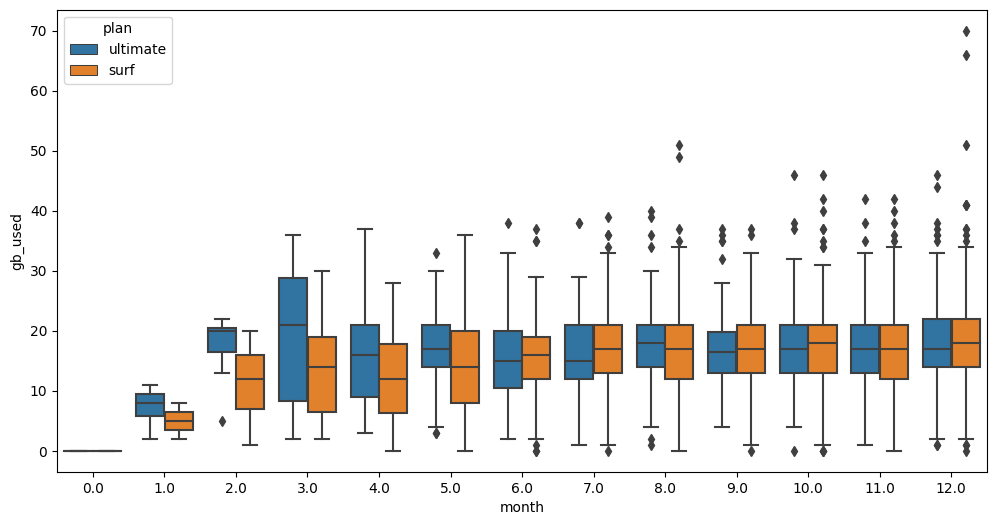

In [ ]:
fig = plt.figure(figsize=(12,6))
sns.boxplot(data=df_combined, x='month', y='gb_used', hue='plan')
plt.show()

Observamos del gráfico que la distribución mensual del consumo de datos para ambos planes es casi la misma, no hay mucha diferencia en los diagramas de caja a excepción de los meses de enero, febrero y marzo pero son casos aislados, en general la distribución es similar en ambos planes donde la mediana es de 16Gb aproximadamente y el 75% del volumen de datos consumidos se encuentra por debajo de los 20Gb.

Observamos también que en promedio, los usuarios con planes ultimate son los que más gigas consumen por mes, aunque no es mucha la diferencia respecto a los usuarios del plan surf.

- En los primeros meses, de enero a mayo, los usuarios del plan ultimate consumían más que los de surf, luego el consumo se fue equiparando en ambos planes.
- Observamos que en promedio a partir del sexto mes, los usuarios del plan surf han superado el límite de consumo de acuerdo al plan que es de 15Gb.

``Recordemos que el mes 0 indica que los usuarios no realizaron ninguna llamada, envio de mensajes o consumo de gigas.``

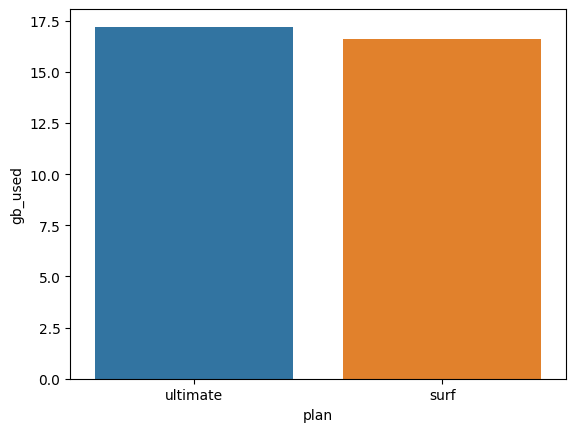

plan
surf        16.607346
ultimate    17.211326
Name: gb_used, dtype: float64

In [ ]:
#comparamos la cantidad promedio de gb usados por plan durante el año 2018 (todos los meses)
sns.barplot(data=df_combined, x='plan', y='gb_used', errorbar=None)
#por defecto estimator=mean y errobar=('ci', 95)
plt.show()
df_combined.groupby('plan')['gb_used'].mean()

En este gráfico se aprecia mejor que los usuarios con plan ultimate y surf prácticamente consumen el mismo volumen de datos en promedio durante todo el año 2018.

- Estas cantidades de mensajes son muy bajas para el plan ultimate ya que dicho plan ofrece 30Gb por mes. 
- Respecto al plan surf, los usuarios exceden el límite de volumen de datos que es de 15Gb por mes.

#### 2. Comparamos la frecuencia de gigabytes que los usuarios de cada plan consumen cada mes.

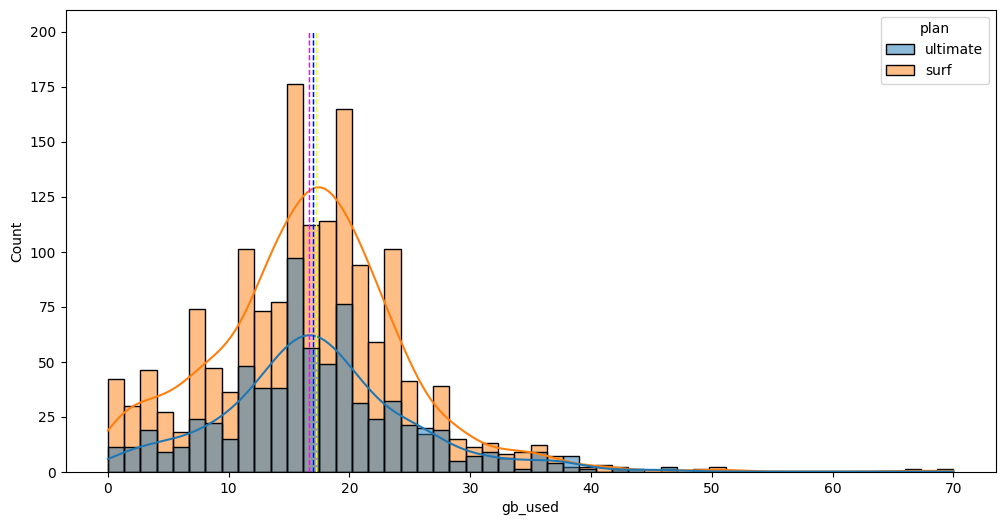

In [ ]:
fig = plt.figure(figsize=(12,6))
sns.histplot(data=df_combined, x='gb_used', hue='plan', kde=True)
plt.vlines(df_combined[df_combined.plan == 'surf']['gb_used'].mean(), colors='magenta', linestyles='dashed', linewidth=1, ymin=0, ymax=200)
plt.vlines(df_combined[df_combined.plan == 'surf']['gb_used'].median(), colors='cyan', linestyles='dashed', linewidth=1, ymin=0, ymax=200)
plt.vlines(df_combined[df_combined.plan == 'ultimate']['gb_used'].mean(), colors='yellow', linestyles='dashed', linewidth=1, ymin=0, ymax=200)
plt.vlines(df_combined[df_combined.plan == 'ultimate']['gb_used'].median(), colors='blue', linestyles='dashed', linewidth=1, ymin=0, ymax=200)
plt.show()

Observamos en el histograma que la media y la mediana no distan mucho, son prácticamente la misma. La distribución es muy parecida a una distribución normal en ambos planes.

También apreciamos que hay ``más frecuencia de gb usados por los usuarios del plan surf``, esto debido a que hay más usuarios de este plan que del plan ultimate.

A continuación mostraremos los valores no solo de la media y mediana sino también de la varianza y la desviación estándar.

In [ ]:
print('USUARIOS DEL PLAN SURF:')
print('Media del volumen de datos usados: ', df_combined[df_combined.plan == 'surf']['gb_used'].mean())
print('Mediana del volumen de datos usados: ', df_combined[df_combined.plan == 'surf']['gb_used'].median())
print('Varianza del volumen de datos usados: ', df_combined[df_combined.plan == 'surf']['gb_used'].var())
print('Desviación estándar del volumen de datos usados: ', df_combined[df_combined.plan == 'surf']['gb_used'].std(), '\n')
print('USUARIOS DEL PLAN ULTIMATE:')
print('Media del volumen de datos usados: ', df_combined[df_combined.plan == 'ultimate']['gb_used'].mean())
print('Mediana del volumen de datos usados: ', df_combined[df_combined.plan == 'ultimate']['gb_used'].median())
print('Varianza del volumen de datos usados: ', df_combined[df_combined.plan == 'ultimate']['gb_used'].var())
print('Desviación estándar del volumen de datos usados: ', df_combined[df_combined.plan == 'ultimate']['gb_used'].std())

USUARIOS DEL PLAN SURF:
Media del volumen de datos usados:  16.60734642178594
Mediana del volumen de datos usados:  17.0
Varianza del volumen de datos usados:  62.40212597053694
Desviación estándar del volumen de datos usados:  7.899501627984955 

USUARIOS DEL PLAN ULTIMATE:
Media del volumen de datos usados:  17.21132596685083
Mediana del volumen de datos usados:  17.0
Varianza del volumen de datos usados:  60.153066565797815
Desviación estándar del volumen de datos usados:  7.755840803278379


- Se aprecia que la variación entre las métricas media y mediana, tanto para los planes ``surf`` y ``ultimate``, es prácticamente cero.
- La varianza en ambos planes es pequeña, esto indica que no hya mucha variación en los gb consumidos respecto a la media.
- Como en ambos planes ocurre lo mismo, esto indica que no hay diferencia en el comportamiento de los usuarios ya sea que usen el plan ``surf`` o ``ultimate``.

**Conclusiones respecto al comportamiento de los usuarios referente al volumen de datos por plan ``surf y ultimate``:**
- El promedio del consumo de datos por mes y por plan es prácticamente el mismo en ambos planes, en los primeros 5 meses había más consumo de los usuarios ultimate pero luego se igualó el consumo mensual promedio entre ambos planes.
- El promedio anual del consumo de datos por plan es prácticamente el mismo en ambos planes (16Gb).
- La media, la mediana, la desviación estándar y la varianza del consumo de datos entre ambos planes es prácticamente el mismo. La viarianza y la desviación estándar es pequeña, lo que indica que no hay mucha variación respecto a la media en ambos planes.
- La frecuencia en el consumo de datos para los planes surf y ultimate son distintos, se observa que hay más frecuencia en el consumo de datos para los planes surf que ultimate. Esto se debe a que hay más usuarios que pertenecen al plan sur que a utlimate.
- La distribución del consumo de datos por mes en ambos planes no varía mucho, según los diagramas de cajas existen mínimos de 0 Gb y el 75% del volumen de datos consumidos está por debajo de 20Gb aproximadamente.

Por consiguiente *``no existe diferencia en el comportamiento de los usuarios en referencia a los datos consumidos, el histograma de ambos planes sigue una distribución normal y el promedio de consumo de gigabytes y la varianza es prácticamente la misma en ambos planes``*.

## **Estudiamos el ingreso entre los planes**

#### 1. Trazamos un diagrama de caja para visualizar la distribución de los ingresos mensuales por plan

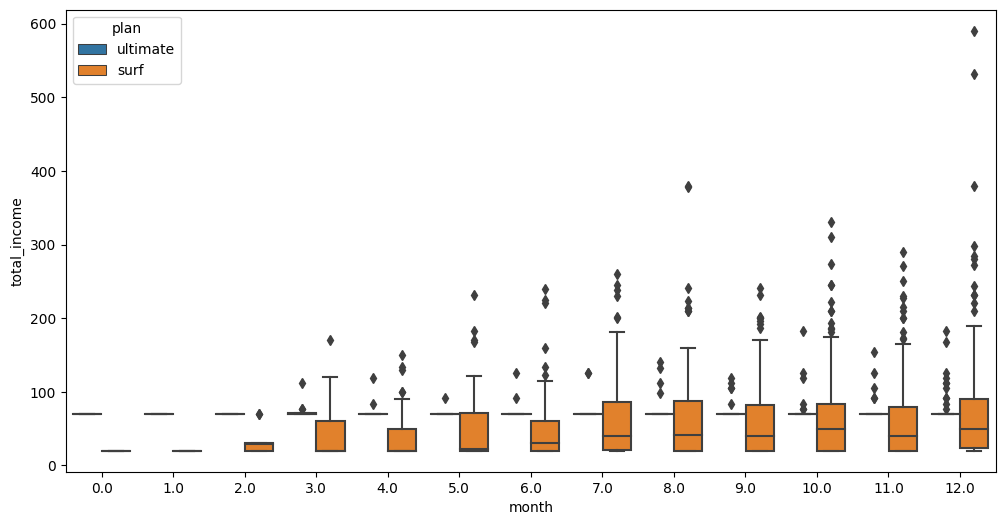

In [ ]:
fig = plt.figure(figsize=(12,6))
sns.boxplot(df_combined, x='month', y='total_income', hue='plan')
plt.show()

- Observamos en el gráfico de cajas que los ingresos del plan ultimate se concentran en USD 70 principalmente habiendo algunos caso raros(muy pocos, es decir atípicos) que superan este valor. 
- Respecto al plan surf hay más variabilidad en los ingresos concentrándose el 75% de los ingresos por debajo de los USD 80.

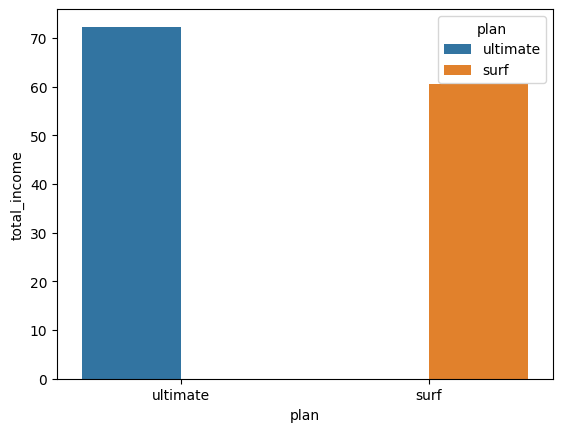

plan
surf        60.551729
ultimate    72.301105
Name: total_income, dtype: float64

In [ ]:
#PROMEDIO ANUAL DE INGRESOS DE ACUERDO AL PLAN
sns.barplot(data=df_combined, x='plan', y='total_income', hue='plan', errorbar=None)
plt.show()
df_combined.groupby('plan')['total_income'].mean()

Observamos que el ingreso promedio mensual y anual de ambos planes es diferente. El plan ultimate genera más ingresos que el plan surf.

#### 2. Comparamos la frecuencia de ingresos de cada plan.

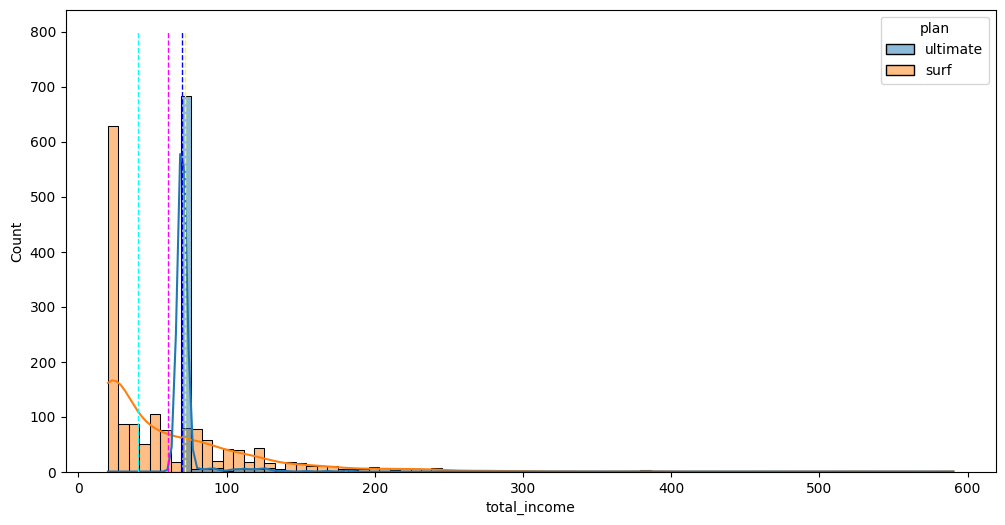

In [ ]:
fig = plt.figure(figsize=(12,6))
sns.histplot(df_combined, x='total_income', hue='plan', kde=True)
plt.vlines(df_combined[df_combined.plan == 'surf']['total_income'].mean(), colors='magenta', linestyles='dashed', linewidth=1, ymin=0, ymax=800)
plt.vlines(df_combined[df_combined.plan == 'surf']['total_income'].median(), colors='cyan', linestyles='dashed', linewidth=1, ymin=0, ymax=800)
plt.vlines(df_combined[df_combined.plan == 'ultimate']['total_income'].mean(), colors='yellow', linestyles='dashed', linewidth=1, ymin=0, ymax=800)
plt.vlines(df_combined[df_combined.plan == 'ultimate']['total_income'].median(), colors='blue', linestyles='dashed', linewidth=1, ymin=0, ymax=800)
plt.show()

- Observamos que la mayor parte de ingresos del plan surf corresponde a USD 20 y del plan ultimate corresponde a USD 70. 
- En el plan surf hay más excesos (plan normal es USD 20 por 15Gb, 50 mensajes y 500 minutos) en el límite que ofrece dicho plan, por ello se observa que las barras son más altas que los del plan ultimate cuando los ingresos son mayores a USD 20 a excepción únicamente de USD 70 que es el costo del plan ultimate.

In [ ]:
print('USUARIOS DEL PLAN SURF:')
print('Media de los ingresos: ', df_combined[df_combined.plan == 'surf']['total_income'].mean())
print('Mediana de los ingresos: ', df_combined[df_combined.plan == 'surf']['total_income'].median())
print('Varianza de los ingresos: ', df_combined[df_combined.plan == 'surf']['total_income'].var())
print('Desviación estándar de los ingresos: ', df_combined[df_combined.plan == 'surf']['total_income'].std(), '\n')
print('USUARIOS DEL PLAN ULTIMATE:')
print('Media de los ingresos: ', df_combined[df_combined.plan == 'ultimate']['total_income'].mean())
print('Mediana de los ingresos: ', df_combined[df_combined.plan == 'ultimate']['total_income'].median())
print('Varianza de los ingresos: ', df_combined[df_combined.plan == 'ultimate']['total_income'].var())
print('Desviación estándar de los ingresos: ', df_combined[df_combined.plan == 'ultimate']['total_income'].std())

USUARIOS DEL PLAN SURF:
Media de los ingresos:  60.551728942368584
Mediana de los ingresos:  40.18
Varianza de los ingresos:  3062.4468636121587
Desviación estándar de los ingresos:  55.33937895940068 

USUARIOS DEL PLAN ULTIMATE:
Media de los ingresos:  72.3011049723757
Mediana de los ingresos:  70.0
Varianza de los ingresos:  129.15955617707067
Desviación estándar de los ingresos:  11.364838590013967


- Se aprecia que la variación entre las métricas, tanto para los planes ``surf`` y ``ultimate``, es diferente.
- La varianza en el plan surf es elevada, esto indica hay mucha variación en los ingresos respecto a la media a diferencia del plan ultimate cuya varianza es pequeña.
- La media y la mediana de ambos ingresos también es diferente.
- La ``mediana del plan ultimate es USD 70 y del plan surf es USD 40``. Lo que indica que los mayores ingresos provienen del plan ultimate.
- Como entre ambos planes existen diferencias, esto indica que hay diferencia en los ingresos para el plan ``surf`` y ``ultimate``.

#### 4. Comparamos la correlación entre los ingresos y los mensajes enviado, los minutos consumidos y los datos usados.

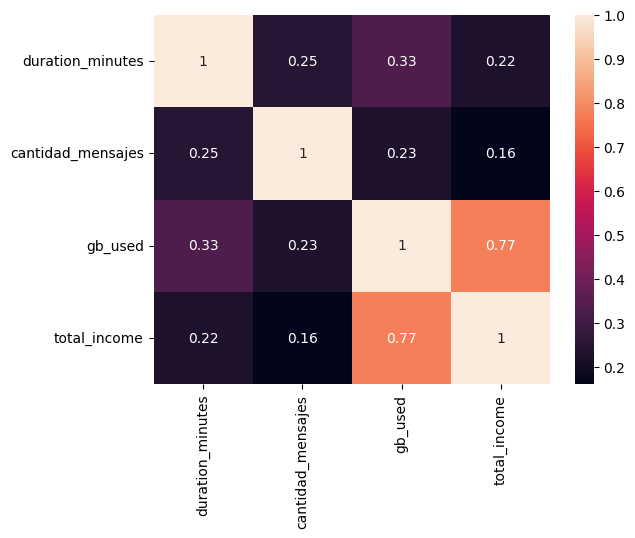

In [ ]:
sns.heatmap(df_combined[['duration_minutes', 'cantidad_mensajes', 'gb_used', 'total_income']].corr(), annot=True)
plt.show()

Conclusiones respecto a los ingresos por plan ``surf y ultimate``:
- El promedio mensual de los ingresos es diferente, siendo mayor el ingreso en el plan ultimate respecto al plan surf.
- El promedio anual de los ingresos es mayor en los usuarios del plan ultimate, USD 72 fente a USD 60 del plan surf.
- La mediana anual de los ingresos es mayor en los usuarios del plan ultimate, USD 70 fente a USD 40 del plan surf.
- La desviación estándar y la varianza por plan es muy diferente, presentando mayor variablidad respecto a la media los usuarios del plan surf.
- La frecuencia de los ingresos para los planes surf y ultimate son distintos, se observa que hay dos picos claramente marcados: los del plan ultimate alrededor de USD 70 y los del plan surf alrededor de USD 20.
- La distribución de los ingresos por mes en ambos planes varía uno con respecto al otro, según los diagramas de cajas los ingresos del plan ultimate se concentran alrededor de los USD 70 principalmente mientras que el 75% de los ingresos del plan surf es menor a USD 80.
- El factor que más aporta a los ingresos mensuales de la compañía es el volumen de datos consumidos, se observa en el mapa de calor que la correlación entre ambos es del 0.77.

Por consiguiente estos análisis dan indicios de que *``existe diferencia en los ingresos que recibe la empresa Megaline por cada plan recibiendo más ingresos por parte de los usuarios ultimate que los usuarios surf.``*, sin embargo esto lo validaremos con una prueba de hipótesis para estar seguros, al menos con un 95% de confianza de que existen diferencias entre ambos planes.

> **Resumiendo respecto al comportamiento de los usuarios y los ingresos:**
>- ``No existe diferencia`` en el comportamiento de los usuarios respecto a las llamadas, sean del plan ultimate o surf.
>- ``Existe diferencia`` en el comportamiento de los usuarios respecto a los mensajes enviados en ambos planes, ultimate y surf.
>- ``No existe diferencia`` en el comportamiento de los usuarios respecto a los volumenes de datos consumidos, sean del plan ultimate o surf.
>- Comprobaremos mediante prueba de hipótesis que ``Existe diferencia`` entre los ingresos de los planes surf y ultimate.

## **Probamos Hipótesis Estadísticas**

#### **1. Probamos la hipótesi de que el ingreso promedio de los usuarios de los planes de llamada Ultimate y Surf es diferente**
- H0: El ingreso promedio de los usuarios de los planes de llamada Ultimate y Surf son iguales. (hipótesis nula)
- H1: El ingreso promedio de los usuarios de los planes de llamada Ultimate y Surf no son iguales, son diferentes. (hipótesis alternativa)

In [ ]:
#creamos dos variables para nuestras dos muestras:
ultimate_user = df_combined[df_combined.plan == 'ultimate']['total_income'] #ingresos de los usuarios del plan ultimate
surf_users = df_combined[df_combined.plan == 'surf']['total_income'] #ingresos de los usuarios del plan surf

#nivel de confianza del 95%
alpha = 0.05

#obtenemos el valor del p-value
_, pvalue = sp.stats.ttest_ind(ultimate_user, surf_users, alternative='two-sided')

print(f'p-value: {pvalue}') #mostramos dicho valor

if pvalue < alpha:
   print('Rechazamos la hipótesis nula')
else:
   print('No rechazamos la hipótesis nula')

p-value: 1.724423314124219e-08
Rechazamos la hipótesis nula


La hipótesis nula es rechazada por lo tanto se confirma que el promedio de ingresos de los usuarios con plan surf y ultimate son diferentes. Esto es cierto como vimos en la gráfica de arriba, donde los usuarios del plan ultimate tienen el promedio de ingresos más elevado de USD 72 y los usuarios del plan surf un ingreso promedio de USD 60.

De esta manera queda confirmado de que si *``existe diferencia entre los ingresos del plan surf y ultimate.``*

#### **2. Probamos la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.**
- H0: El ingreso promedio de los usuarios del área NY-NJ es igual al de los usuarios de otras regiones. (hipótesis nula)
- H1: El ingreso promedio de los usuarios del área NY-NJ no es igual al de los usuarios de otras regiones, son diferentes. (hipótesis alternativa)

In [ ]:
#creamos dos variables para nuestras dos muestras:
nynj_income = df_combined[df_combined.city == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['total_income'] #ingresos de los usuarios de la ciudad NY-NJ
other_regions_income = df_combined[df_combined.city != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['total_income'] #ingresos de los usuarios de las otras ciudades

#nivel de confianza del 95%
alpha = 0.05

#obtenemos el valor del p-value
_, pvalue = sp.stats.ttest_ind(nynj_income, other_regions_income, alternative='two-sided')

print(f'p-value: {pvalue}') #mostramos dicho valor

if pvalue < alpha:
   print('Rechazamos la hipótesis nula')
else:
   print('No rechazamos la hipótesis nula')

p-value: 0.04974528277407644
Rechazamos la hipótesis nula


Se rechaza la hipótesis nula, lo que significa que los ingresos promedios de los usuarios de la ciudad NY-NJ son diferentes al de otras ciudades. 

En el código de abajo calculamos las medias para los ingresos de los usuarios de NY-NJ y los ingresos de otras regiones o ciudades. Se observa que las medias son diferentes, es por ello que se rechaza la hipótesis nula.

In [ ]:
print('Media de ingresos de los usuarios de la ciudad NY-NJ: ', df_combined[df_combined.city == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['total_income'].mean())
print('Media de ingresos de los usuarios de otras ciudades: ', df_combined[df_combined.city != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['total_income'].mean())

Media de ingresos de los usuarios de la ciudad NY-NJ:  59.948015873015876
Media de ingresos de los usuarios de otras ciudades:  65.08926233766233


De las medias obtenidas cabe señalar que aparentemente los ingresos de otras ciudades son un poco mayores que los de NY-NJ. 

## **CONCLUSIONES**
- Para poder realizar el análisis de los datos se realizó un preprocesamiento de los mismos identificándose valores nulos, error en el tipo de datos y diferentes nombres en las columnas lo cual no permitía, inicialmente, hacer una unión entre tablas.
- Se reemplazaron los valores nulos, se corrigieron los tipos de datos (principalmente el de tipo fecha) y se renombraron algunas columnas.
- A partir de las tablas originales (04 tablas a excepción de la tabla 'plan') se crearon cuatro nuevas tablas que contienen solamente los campos más importantes para el análisis.
- No se eliminaron los valores atípicos de las nuevas tablas creadas ya que son de interés para el anáisis del comportamiento de los usuarios.
- Se realizó un merge entre las cinco tablas (04 tablas nuevas y la tabla plan) para tener unificado los campos que son más importantes para el análisis en una sola tabla y se facilite el análisis.
- En la nueva tabla combinada se agregó un campo que contiene los ingresos mensuales por usuario y tipo de plan adquirido y también se eliminaron las columnas que no servían para el análisis.
- Se realizó un análisis del comportamiento de los usuarios en referencia a la cantidad de llamadas realizadas, la duración de las llamadas, los mensajes enviados y el volumen de datos consumidos. Para esto se usaron gráficos de barras, gráfico de cajas e histogramas encontrándose:
  - ``No existe diferencia`` en el comportamiento de los usuarios respecto a las llamadas, sean del plan ultimate o surf.
  - ``Existe diferencia`` en el comportamiento de los usuarios respecto a los mensajes enviados en ambos planes, ultimate y surf.
  - ``No existe diferencia`` en el comportamiento de los usuarios respecto a los volumenes de datos consumidos, sean del plan ultimate o surf.
  - Aproximadamente el 22% de los registros de los usuarios no envian mensajes, la cantidad es cero.
  - Tanto los usuarios del plan surf como los del plan ultimate no llegan a consumir todos los beneficios de su plan ``principalmente la cantidad de mensajes y los minutos para llamar``. Sin embargo respecto a los gigabytes consumidos, los usuarios del plan surf tienden a ``sobrepasar el límite de su plan de consumo que es de 15 GB.``
  - Exiten usuarios que ``no realizaron ningún consumo de su plan`` durante todo el año 2018.
- Se realizó un análisis de los ingresos por cada plan usando gráfico de barras, histogramas, gráfico de cajas y mapa de calor determinándose:
  - ``Existe diferencia`` entre los ingresos de los planes surf y ultimate.
  - Los usuarios del ``plan ultimate generan mayores ingresos`` para la empresa Megaline.
  - Existe ``correlación lineal de 0.77 entre la cantidad de gigas consumidos y los ingresos generados``.
- Se realizó una prueba estadística para comprobar la hipótesis nula de que el promedio de ingresos de los usuarios de los planes surf y ultimate son iguales. Se concluyó que:
  - La ``hipótesis nula fue rechazada por lo que los ingresos promedios provenientes de ambos planes es diferente``, siendo mayor el ingreso promedio proveniente del ``plan ultimate, $72``, frente al ingreso promedio del ``plan surf, $60``.
- Se realizó otra prueba estadística para comprobar la hipótesis nula de que el promedio de ingresos de los usuarios de la ciudad NY-NY es igual al de otras ciudades. Se concluyó que:
  - ``Se rechaza la hipótesis nula``, lo que significa que ``los ingresos promedios de los usuarios de la ciudad NY-NJ son diferentes a las de las otras ciudades`` siendo el ingreso medio en otras ciudades de $65 y en la ciudad de NY-NJ de $59.9.

## **CONCLUSION GENERAL**
De los resultads obtenidos:
- Se recomienda invertir más en publicidad para el plan Ultimate, ya que genera más ingresos en promedio. 
- Asimismo, se recomienda invertir más en publicidad para los Estados fuera de NY-NJ, ya que también aparentemente generan más ingresos.